### 1. Load MongoDB, check docs load

In [51]:
from pymongo import MongoClient
# created 'proj7db' in mongo shell somehow
# https://www.mongodb.com/basics/create-database

# Instantiate client; confirm 'proj7db' among available databases
client = MongoClient()
assert 'proj7db' in client.list_database_names()

# Define working db
db = client.proj7db

# Define working collection
prices = db.prices

# Confirm one record has been added
prices.count_documents({})

7

### 2. Read record(s) from mongoDB

In [52]:
import numpy as np
import pandas as pd
from pprint import pprint

# Put all NVDA quotes in the cursor
# cursor[0] = 0900 quotes, cursor[1] = 1000 quotes, ..., cursor[7] = 1700 quotes

cursor = list(prices.find({'symbol':'NVDA'}, {'_id': 0, 
                                              'symbol': 1, 
                                              'underlyingPrice': 1,
                                              'timestamp': 1,
                                              'callExpDateMap': 1,
                                              'putExpDateMap': 1}))

print(cursor[-1]['timestamp'])

1500


In [53]:
# Load the most recent doc in the collection: cursor[-1]

test_json_p = cursor[-1]['putExpDateMap']
test_json_c = cursor[-1]['callExpDateMap']
#pprint(test_json_c)

In [16]:
# Get list of expiry dates (top level in document)
dates = list(test_json_c.keys())
print(f'{len(dates)} expiry dates on chain')
print(dates)

18 expiry dates on chain
['2021-12-17:1', '2021-12-23:7', '2021-12-31:15', '2022-01-07:22', '2022-01-14:29', '2022-01-21:36', '2022-01-28:43', '2022-02-18:64', '2022-03-18:92', '2022-04-14:119', '2022-05-20:155', '2022-06-17:183', '2022-07-15:211', '2022-09-16:274', '2023-01-20:400', '2023-03-17:456', '2023-06-16:547', '2024-01-19:764']


In [17]:
# Get list of all possible strikes (next level)
strikes = []
for date in dates:
    db = test_json_c[date]
    strike = [float(key) for key in db.keys()]
    strikes += strike
    
strikes = [str(strike) for strike in list(np.unique(strikes))]  # type conversion needed bc np.unique() sorts alphabetically (e.g. 60>500)

print(f'{len(strikes)} strike prices on chain')
print([f'${strike}' for strike in strikes])

261 strike prices on chain
['$22.5', '$23.75', '$25.0', '$26.25', '$27.5', '$28.75', '$30.0', '$31.25', '$32.5', '$33.75', '$35.0', '$36.25', '$37.5', '$38.75', '$40.0', '$41.25', '$42.5', '$43.75', '$45.0', '$46.25', '$47.5', '$48.75', '$50.0', '$51.25', '$52.5', '$53.75', '$55.0', '$56.25', '$57.5', '$60.0', '$62.5', '$65.0', '$67.5', '$70.0', '$72.5', '$75.0', '$77.5', '$78.75', '$80.0', '$82.5', '$85.0', '$87.5', '$90.0', '$92.5', '$95.0', '$97.5', '$100.0', '$102.5', '$105.0', '$107.5', '$110.0', '$112.5', '$115.0', '$116.25', '$117.5', '$118.75', '$120.0', '$121.25', '$122.5', '$123.75', '$125.0', '$126.25', '$127.5', '$128.75', '$130.0', '$131.25', '$132.5', '$133.75', '$135.0', '$136.25', '$137.5', '$138.75', '$140.0', '$141.25', '$142.5', '$143.75', '$145.0', '$146.25', '$147.5', '$148.75', '$150.0', '$151.25', '$152.5', '$153.75', '$155.0', '$156.25', '$157.5', '$158.75', '$160.0', '$161.25', '$162.5', '$163.75', '$165.0', '$166.25', '$167.5', '$168.75', '$170.0', '$171.25', 

### 3. Convert JSONs to dataframe

In [54]:
def prep_df_from_json(json, name):
    df = pd.DataFrame(json)
    vals = list(df.values.flatten())
    
    df_new = []
    for entry in vals:
        if entry is not np.nan:
            df_new.append(entry[0])
    
    print(f'Total of {len(df_new)} {name} contracts')
        
    df = pd.DataFrame(tuple(df_new))
    
    return df

df_c = prep_df_from_json(test_json_c, "call")
df_p = prep_df_from_json(test_json_p, "put")
df = pd.concat([df_c, df_p], axis=0, ignore_index=True)

Total of 1697 call contracts
Total of 1697 put contracts


In [55]:
# Label these records for slider on webapp
df['timeofday'] = 1500

In [9]:
# TO DO: Convert epoch time to yyyy-mm-dd time
df.expirationDate

0       1639774800000
1       1642798800000
2       1655496000000
3       1663358400000
4       1674248400000
            ...      
3389    1674248400000
3390    1674248400000
3391    1674248400000
3392    1674248400000
3393    1674248400000
Name: expirationDate, Length: 3394, dtype: int64

In [28]:
# Inspect before saving
(df[['symbol', 'description', 'timeofday', 'putCall',
    'expirationDate', 'strikePrice', 'bid', 'ask', 'last', 'mark']])

,symbol,description,timeofday,putCall,expirationDate,strikePrice,bid,ask,last,mark
0,NVDA_121721C70,NVDA Dec 17 2021 70 Call,1200,CALL,1639774800000,70.00,215.05,216.10,215.90,215.58
1,NVDA_012122C70,NVDA Jan 21 2022 70 Call,1200,CALL,1642798800000,70.00,214.95,216.70,243.77,215.83
2,NVDA_061722C70,NVDA Jun 17 2022 70 Call,1200,CALL,1655496000000,70.00,215.55,217.30,224.56,216.43
3,NVDA_091622C70,NVDA Sep 16 2022 70 Call,1200,CALL,1663358400000,70.00,216.00,217.90,248.00,216.95
4,NVDA_012023C70,NVDA Jan 20 2023 70 Call,1200,CALL,1674248400000,70.00,216.80,218.75,202.98,217.78
...,...,...,...,...,...,...,...,...,...,...
3389,NVDA_012023P118.75,NVDA Jan 20 2023 118.75 Put,1200,PUT,1674248400000,118.75,3.45,3.75,3.20,3.60
3390,NVDA_012023P121.25,NVDA Jan 20 2023 121.25 Put,1200,PUT,1674248400000,121.25,3.65,3.95,3.55,3.80
3391,NVDA_012023P123.75,NVDA Jan 20 2023 123.75 Put,1200,PUT,1674248400000,123.75,3.85,4.20,3.55,4.03
3392,NVDA_012023P126.25,NVDA Jan 20 2023 126.25 Put,1200,PUT,1674248400000,126.25,4.05,4.40,4.57,4.22


In [56]:
# Save to file for streamlit app
df.to_csv('data/df_1500.csv')

### 4. Preview visualization

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [ ]:
# Visualize options chain as 3D scatter plot
# Prepare figure parameters
fig = plt.figure(figsize=(10,100))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Strike Price ($)')
ax.set_ylabel('Expiration Date (epoch)')
ax.set_zlabel('Option Price ($)')

ax.set_xlim(left=250, right=350)
ax.set_ylim(bottom=1639774800000, top=1642496000000)
ax.set_zlim(bottom=0, top=500)

0       v
1       v
2       v
3       v
4       v
       ..
1692    v
1693    v
1694    v
1695    v
1696    v
Name: icon, Length: 1697, dtype: object

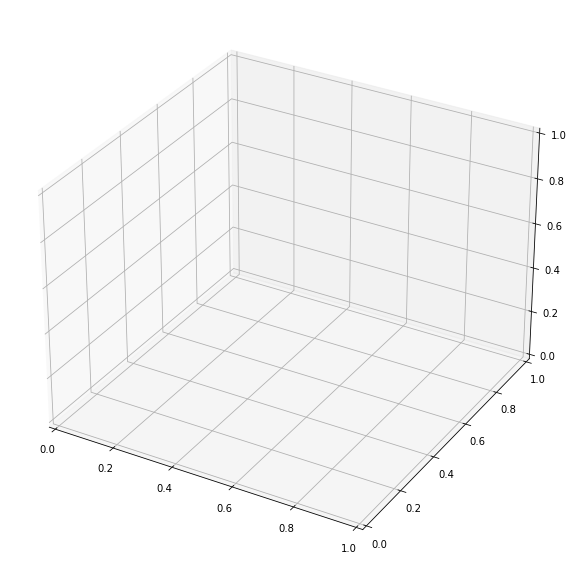

In [83]:
# Get features for plotting
# Set first quote of day as baseline
df_0 = pd.read_csv('data/df_0900.csv')

# Get percent change from baseline
df['pctChange'] = (df['mark'] / df_0['mark']) - 1.

In [84]:
df_c = df[(df.putCall == 'CALL')]
x = df_c['strikePrice']
y = df_c['expirationDate']
z = df_c['mark']

hue = df_c['pctChange']
marker = '^'

ax.scatter(x, y, z, 
           c=hue.map(cm.PuOr), 
           marker=marker)
ax.set_box_aspect((1, 3, 1))



ax.view_init(20, -60)
plt.show()

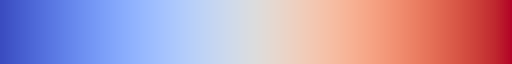

In [48]:
df_p = df[(df.putCall == 'PUT')]